## HW 0 ECON 522

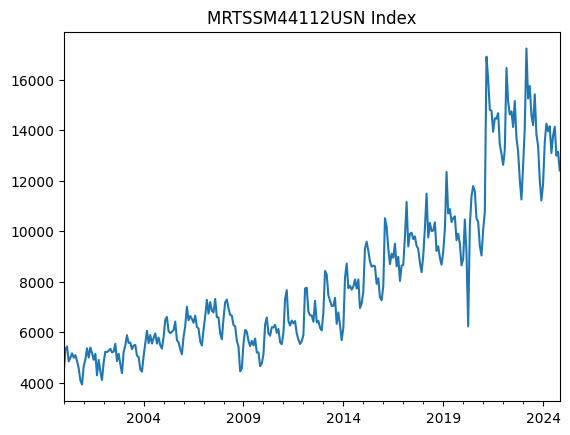

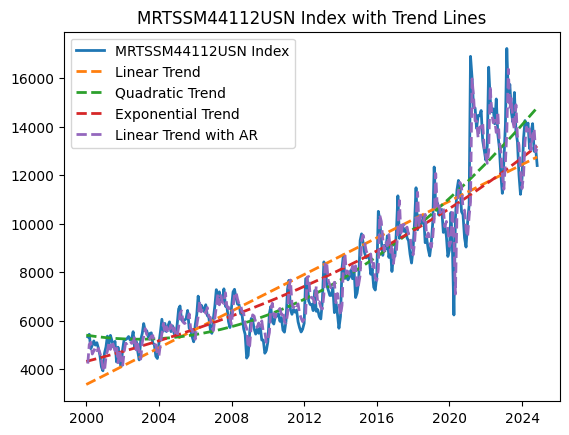

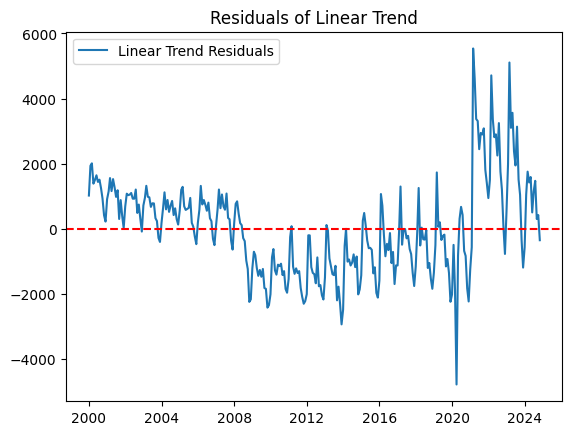

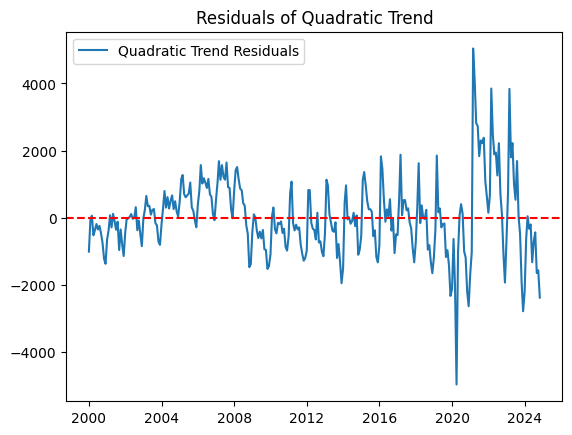

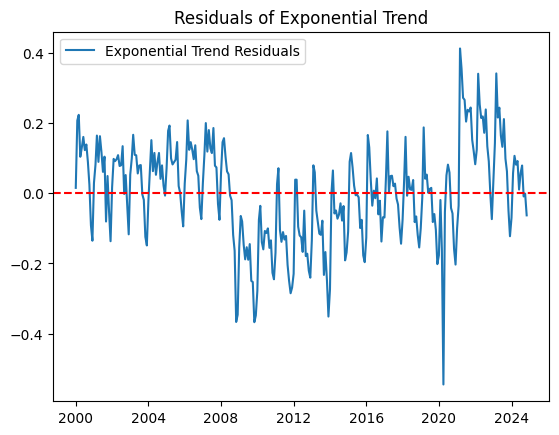

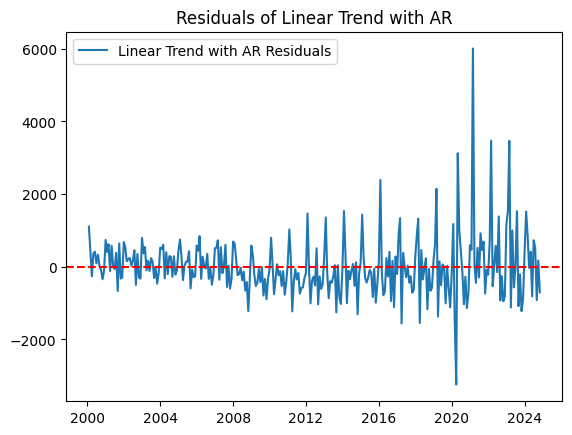

                  Model          AIC          BIC
0          Linear Trend  5207.579370  5214.980257
1       Quadratic Trend  5057.440235  5068.541566
2     Exponential Trend  -318.781822  -311.380935
3  Linear Trend with AR  4849.281045  4860.372325


In [6]:
from fredapi import Fred
import pandas as pd
from statsmodels.api import OLS
from statsmodels.tools import add_constant
import numpy as np

import matplotlib.pyplot as plt

def analyze_fred_data(series_id):
    # Replace 'your_api_key' with your actual FRED API key
    fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')

    # Download data from FRED
    data = fred.get_series(series_id, observation_start='2000-01-01')
    data_df = data.to_frame(name=series_id)
    
    # Plot the data
    data_df.plot(title=f'{series_id} Index', legend=None)
    plt.show()

    # Prepare data for modeling
    t = range(len(data_df))
    X = pd.DataFrame({'t': t}, index=data_df.index)
    X = add_constant(X)

    # Linear Trend Model
    model_linear = OLS(data_df, X)
    results_linear = model_linear.fit()

    # Quadratic Trend Model
    t_squared = [i**2 for i in t]
    X_quad = pd.DataFrame({'t': t, 't_squared': t_squared}, index=data_df.index)
    X_quad = add_constant(X_quad)
    model_quad = OLS(data_df[series_id], X_quad)
    results_quad = model_quad.fit()

    # Exponential Trend Model
    data_log = np.log(data_df[series_id])
    model_exp = OLS(data_log, X)
    results_exp = model_exp.fit()

    # Linear Trend with AR Model
    data_df['LAG1'] = data_df[series_id].shift(1)
    data_df = data_df.dropna()
    X_with_lag = X.iloc[1:].copy()
    X_with_lag['LAG1'] = data_df['LAG1']
    model_with_lag = OLS(data_df[series_id], X_with_lag)
    results_with_lag = model_with_lag.fit()

    # Plot the data with trend lines
    plt.figure()
    plt.plot(data_df[series_id], label=f'{series_id} Index', linewidth=2)
    plt.plot(results_linear.fittedvalues, label='Linear Trend', linestyle='--', linewidth=2)
    plt.plot(results_quad.fittedvalues, label='Quadratic Trend', linestyle='--', linewidth=2)
    plt.plot(np.exp(results_exp.fittedvalues), label='Exponential Trend', linestyle='--', linewidth=2)
    plt.plot(results_with_lag.fittedvalues, label='Linear Trend with AR', linestyle='--', linewidth=2)
    plt.legend()
    plt.title(f'{series_id} Index with Trend Lines')
    plt.show()

    # Plot the residuals
    plt.figure()
    plt.plot(results_linear.resid, label='Linear Trend Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of Linear Trend')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(results_quad.resid, label='Quadratic Trend Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of Quadratic Trend')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(results_exp.resid, label='Exponential Trend Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of Exponential Trend')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(results_with_lag.resid, label='Linear Trend with AR Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of Linear Trend with AR')
    plt.legend()
    plt.show()

    # Compare models using AIC and BIC
    models = {
        'Linear Trend': results_linear,
        'Quadratic Trend': results_quad,
        'Exponential Trend': results_exp,
        'Linear Trend with AR': results_with_lag
    }

    comparison_data = []
    for model_name, model_results in models.items():
        comparison_data.append({
            'Model': model_name,
            'AIC': model_results.aic,
            'BIC': model_results.bic
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df)

# Example usage
analyze_fred_data('MRTSSM44112USN')

In [9]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

def test_break_in_trend(data_df, series_id, break_year):
    """
    Tests for a structural break in the trend in the specified year using a Chow test.
    
    Parameters:
        data_df (pd.DataFrame): The data DataFrame containing the series and its lag.
        series_id (str): The column name of the time series in the DataFrame.
        break_year (int): The year at which to test for a structural break.
        
    Returns:
        None: Prints the result of the Chow test.
    """
    # Ensure data is properly indexed by datetime
    if not isinstance(data_df.index, pd.DatetimeIndex):
        data_df.index = pd.to_datetime(data_df.index)

    # Define the breakpoint
    break_point = data_df[data_df.index.year == break_year].index[0]

    # Prepare the data for the Chow test
    # Use the same lag model as before
    data_df['LAG1'] = data_df[series_id].shift(1)
    data_df = data_df.dropna()
    
    t = range(len(data_df))
    X = pd.DataFrame({'t': t}, index=data_df.index)
    X = add_constant(X)
    X['LAG1'] = data_df['LAG1']
    
    # Fit the model
    model = OLS(data_df[series_id], X)
    results = model.fit()

    # Perform the CUSUM test for structural breaks
    cusum_test = breaks_cusumolsresid(results.resid, ddof=X.shape[1])

    print(f"CUSUM Test Result for Break in {break_year}:")
    print(f"Statistic: {cusum_test[0]}, p-value: {cusum_test[1]}")
    if cusum_test[1] < 0.05:
        print(f"Evidence of a structural break at {break_year} (p < 0.05).")
    else:
        print(f"No evidence of a structural break at {break_year} (p >= 0.05).")

# Step 1: Fetch data using the FRED API
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')
series_id = 'MRTSSM44112USN'
data = fred.get_series(series_id, observation_start='2000-01-01')

# Convert the series to a DataFrame
data_df = data.to_frame(name=series_id)

# Step 2: Run the structural break test
test_break_in_trend(data_df, series_id, 2008)

CUSUM Test Result for Break in 2008:
Statistic: 1.2281342238248814, p-value: 0.09792067423757331
No evidence of a structural break at 2008 (p >= 0.05).


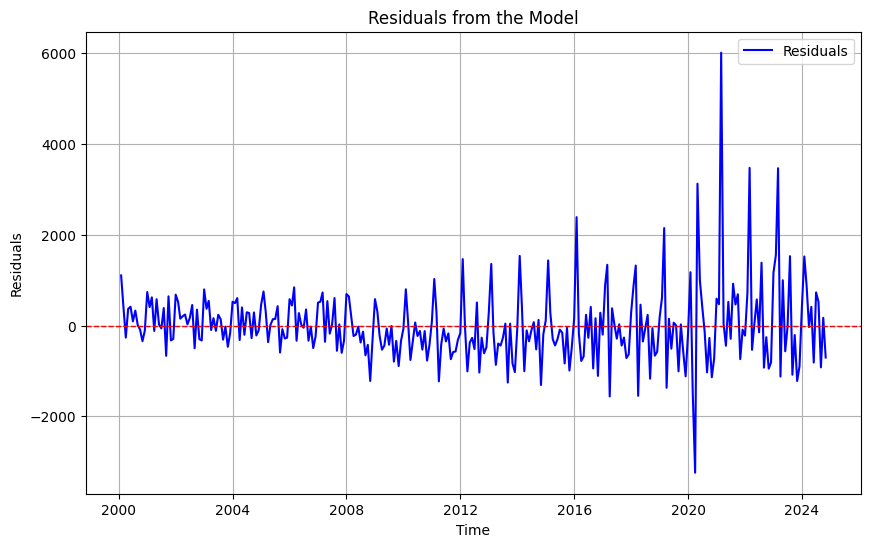

<Figure size 1000x600 with 0 Axes>

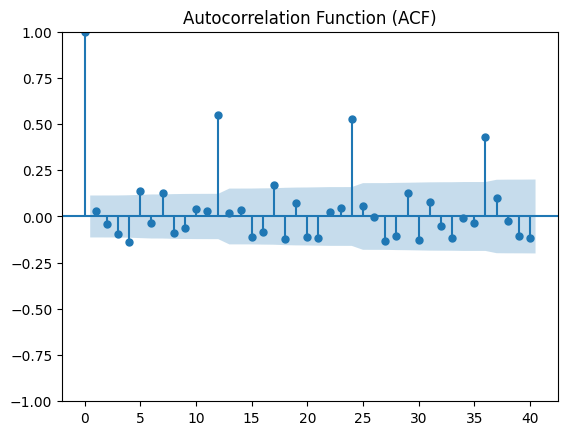

<Figure size 1000x600 with 0 Axes>

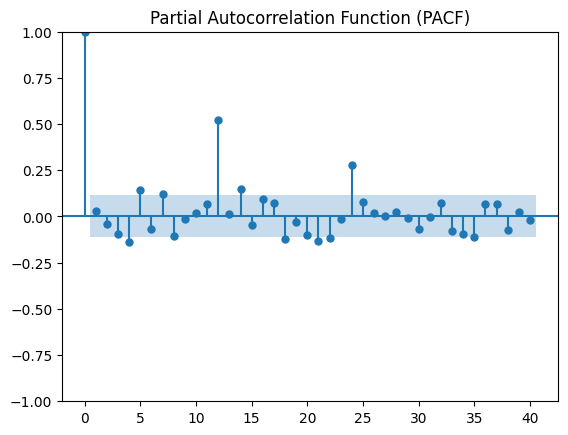

In [10]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_residuals_and_correlogram(residuals):
    """
    Plots the residuals and their correlogram (ACF and PACF).
    
    Parameters:
        residuals (pd.Series): The residuals from the regression model.
    
    Returns:
        None: Displays the plots.
    """
    # Plot the residuals
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='blue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Residuals from the Model')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the correlogram (ACF and PACF)
    plt.figure(figsize=(10, 6))
    plot_acf(residuals, lags=40, title='Autocorrelation Function (ACF)')
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(residuals, lags=40, title='Partial Autocorrelation Function (PACF)')
    plt.show()

# Example usage
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')
series_id = 'MRTSSM44112USN'
data = fred.get_series(series_id, observation_start='2000-01-01')
data_df = data.to_frame(name=series_id)

# Add lag and fit the model
data_df['LAG1'] = data_df[series_id].shift(1)
data_df = data_df.dropna()
t = range(len(data_df))
X = pd.DataFrame({'t': t}, index=data_df.index)
X = add_constant(X)
X['LAG1'] = data_df['LAG1']

model = OLS(data_df[series_id], X)
results = model.fit()

# Get residuals
residuals = results.resid

# Plot residuals and correlogram
plot_residuals_and_correlogram(residuals)

                            OLS Regression Results                            
Dep. Variable:         MRTSSM44112USN   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1300.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          2.64e-169
Time:                        12:44:31   Log-Likelihood:                -2420.7
No. Observations:                 298   AIC:                             4849.
Df Residuals:                     294   BIC:                             4864.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         628.6647    146.321      4.296      

/var/folders/ch/hh05jl8911q5dhp_1wptbrym0000gn/T/ipykernel_9897/3183494327.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['COVID_DUMMY'] = ((data_df.index >= covid_start) & (data_df.index <= covid_end)).astype(int)


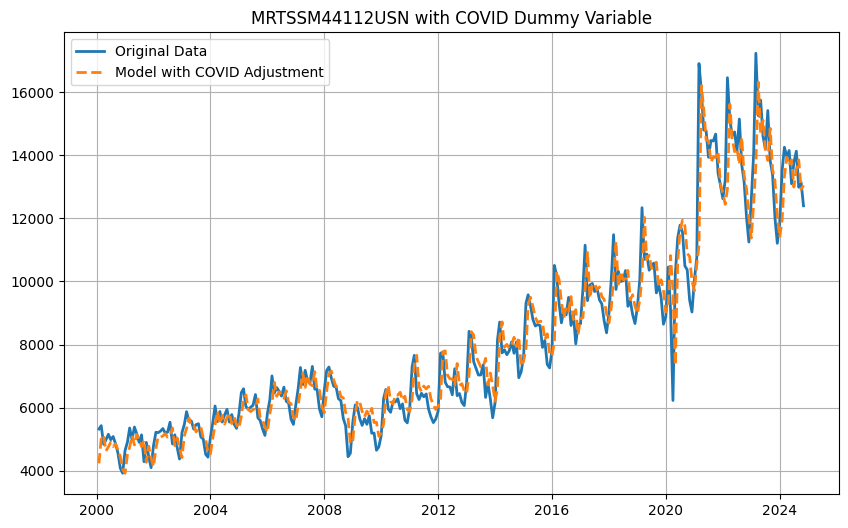

In [12]:
def analyze_with_covid_dummy(data_df, series_id):
    """
    Analyze the time series data while accounting for the COVID period using a dummy variable.
    
    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the time series data.
        series_id (str): The column name of the time series in the DataFrame.
        
    Returns:
        results_with_covid (OLSResults): The regression results including the COVID dummy.
    """
    # Add lag
    data_df['LAG1'] = data_df[series_id].shift(1)
    data_df = data_df.dropna()

    # Create a time variable
    t = range(len(data_df))
    X = pd.DataFrame({'t': t}, index=data_df.index)
    X = add_constant(X)

    # Add COVID dummy variable (March 2020 to December 2021)
    covid_start = pd.Timestamp('2020-03-01')
    covid_end = pd.Timestamp('2021-08-31')
    data_df['COVID_DUMMY'] = ((data_df.index >= covid_start) & (data_df.index <= covid_end)).astype(int)
    X['LAG1'] = data_df['LAG1']
    X['COVID_DUMMY'] = data_df['COVID_DUMMY']

    # Fit the model
    model = OLS(data_df[series_id], X)
    results_with_covid = model.fit()

    # Summary of results
    print(results_with_covid.summary())

    # Plot the data with the adjusted trend
    plt.figure(figsize=(10, 6))
    plt.plot(data_df[series_id], label='Original Data', linewidth=2)
    plt.plot(results_with_covid.fittedvalues, label='Model with COVID Adjustment', linestyle='--', linewidth=2)
    plt.title(f'{series_id} with COVID Dummy Variable')
    plt.legend()
    plt.grid()
    plt.show()

    return results_with_covid

# Example usage
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')
series_id = 'MRTSSM44112USN'
data = fred.get_series(series_id, observation_start='2000-01-01')
data_df = data.to_frame(name=series_id)

# Analyze the series with a COVID dummy variable
results_with_covid = analyze_with_covid_dummy(data_df, series_id)

                            OLS Regression Results                            
Dep. Variable:         MRTSSM44112USN   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           1.50e-99
Time:                        12:48:55   Log-Likelihood:                -2558.8
No. Observations:                 298   AIC:                             5144.
Df Residuals:                     285   BIC:                             5192.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2678.5758    301.673      8.879      0.0

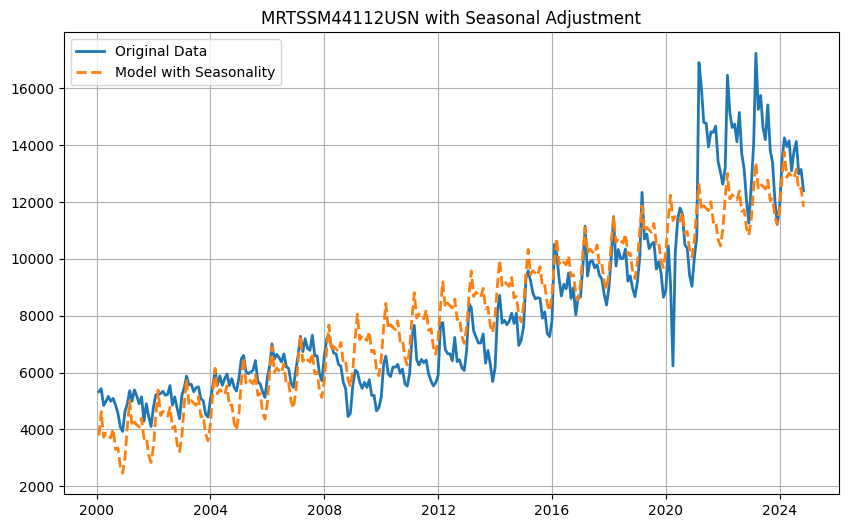

In [15]:
def analyze_with_seasonality(data_df, series_id):
    """
    Analyze the time series data with seasonal dummies to detect seasonality.
    
    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the time series data.
        series_id (str): The column name of the time series in the DataFrame.
        
    Returns:
        results_with_seasonality (OLSResults): The regression results including seasonal dummies.
    """
    # Ensure the series is numeric
    data_df[series_id] = pd.to_numeric(data_df[series_id], errors='coerce')
    data_df = data_df.dropna()  # Drop rows with NaNs caused by type conversion

    # Add lag
    data_df['LAG1'] = data_df[series_id].shift(1)
    data_df = data_df.dropna()

    # Create a time variable
    t = range(len(data_df))
    X = pd.DataFrame({'t': t}, index=data_df.index)
    X = add_constant(X)

    # Add seasonal dummy variables
    data_df['Month'] = data_df.index.month
    seasonal_dummies = pd.get_dummies(data_df['Month'], prefix='Month', drop_first=True)
    X = pd.concat([X, seasonal_dummies], axis=1)

    # Ensure all inputs are numeric and aligned
    X = X.astype(float)  # Force all X columns to float
    data_df[series_id] = data_df[series_id].astype(float)

    # Ensure index alignment between X and y
    y = data_df[series_id]
    if not X.index.equals(y.index):
        X, y = X.align(y, join='inner', axis=0)

    # Fit the model
    model = OLS(y, X)
    results_with_seasonality = model.fit()

    # Summary of results
    print(results_with_seasonality.summary())

    # Plot the data with the adjusted trend
    plt.figure(figsize=(10, 6))
    plt.plot(data_df[series_id], label='Original Data', linewidth=2)
    plt.plot(results_with_seasonality.fittedvalues, label='Model with Seasonality', linestyle='--', linewidth=2)
    plt.title(f'{series_id} with Seasonal Adjustment')
    plt.legend()
    plt.grid()
    plt.show()

    return results_with_seasonality

# Example usage
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')
series_id = 'MRTSSM44112USN'
data = fred.get_series(series_id, observation_start='2000-01-01')
data_df = data.to_frame(name=series_id)

# Analyze the series with seasonal dummies
results_with_seasonality = analyze_with_seasonality(data_df, series_id)

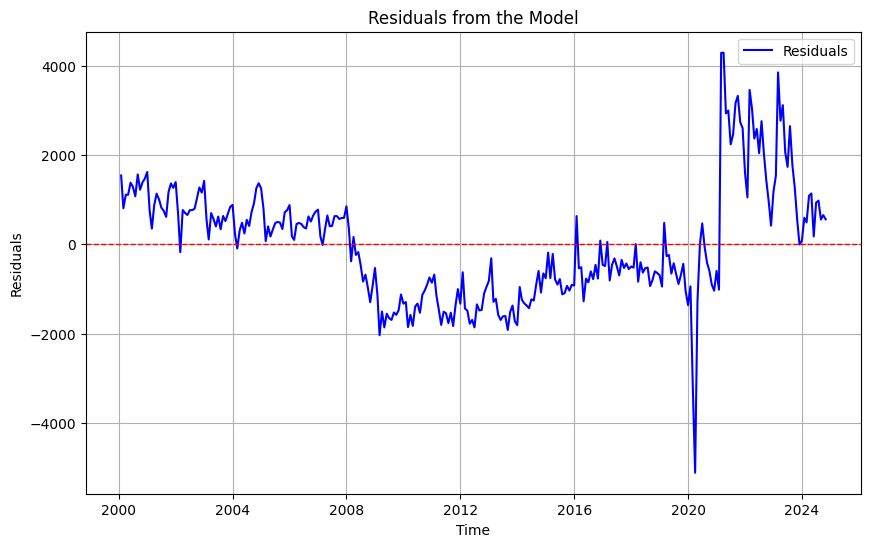

<Figure size 1000x600 with 0 Axes>

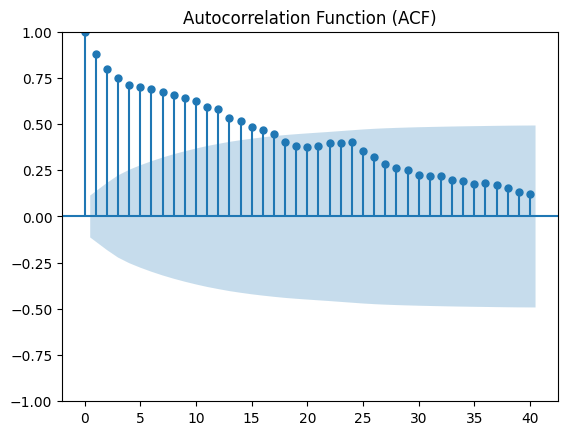

<Figure size 1000x600 with 0 Axes>

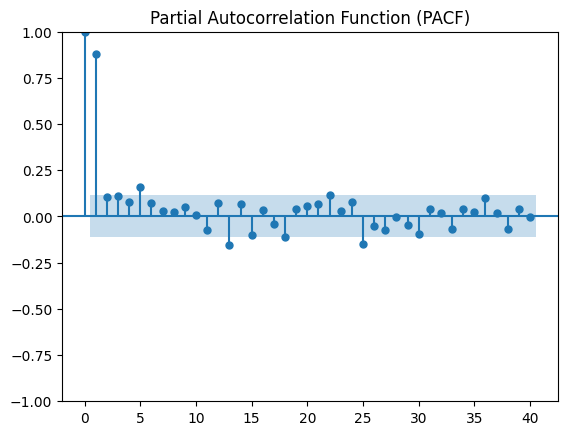

In [19]:
# Plot the residuals and correlogram of this seasonally adjusted model
residuals_seasonal = results_with_seasonality.resid
plot_residuals_and_correlogram(residuals_seasonal)
